In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil

%matplotlib inline

# number of sections
k=3

# value of cumulative pixels that get accepted
val_threshold_bin = 200 #!experimental algo dinamico como otsu ou normalizaçao

#dataset path
path = 'mdsn_no_p/input'

#clean everything inside binary_image folder
shutil.rmtree('binary_image')
os.mkdir('binary_image')

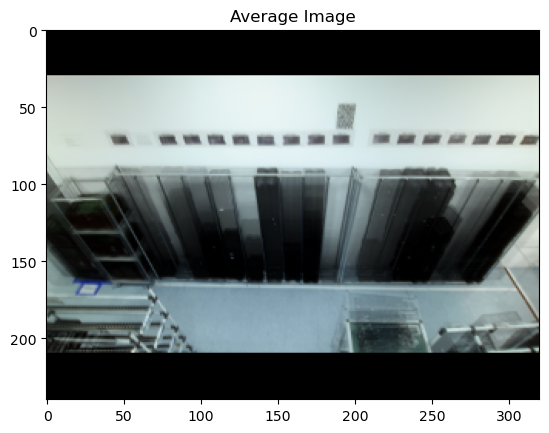

In [43]:
#load all images from the folder mdsn_no_p/input
# and calculate the average of all images
#then show it
images = []
for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path,filename))
    if img is not None:
        images.append(img)

average = np.average(images, axis=0)
average = np.uint8(average)
plt.title('Average Image')
plt.imshow(average)

In [40]:
# [IMPORTANT] THE IDEAL WOULD BE TO FIND THE IMAGE WITH THE MOST FILLED FS AND USE THAT INSTEAD
# Load the image
image = average

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #plt.imshow(image)

    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))

    # Convert to float type
pixel_vals = np.float32(pixel_vals)

    #the below line of code defines the criteria for the algorithm to stop running,
    #which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
    #becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    # then perform k-means clustering wit h number of clusters defined as 3
    #also random centres are initially choosed for k-means clustering
    #k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Reshape the labels into the same shape as the original image
labels = labels.reshape(image.shape[0], image.shape[1])

# Create a blank image to store the binary images
binary_images = np.zeros((image.shape[0], image.shape[1], k), dtype=np.uint8)

# Iterate over each cluster and create a binary image for each
for cluster in range(k):
    binary_images[:,:,cluster] = (labels == cluster).astype(np.uint8) * 255

# Save the binary images
for cluster in range(binary_images.shape[2]):
    cv2.imwrite("binary_image/binary_image_{}.jpg".format(cluster), binary_images[:,:,cluster])


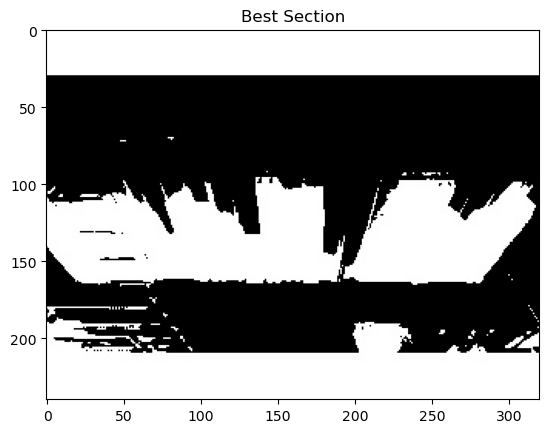

In [44]:
cumulative_sum = cv2.imread('cumulative_sum.png')
ret, cumulative_sum_binary = cv2.threshold(cumulative_sum, val_threshold_bin, 255, cv2.THRESH_BINARY)
#all black image with same size as cumulative_sum
best_image = np.zeros(cumulative_sum.shape, np.uint8)
best_image_count = cv2.countNonZero(cv2.cvtColor(best_image, cv2.COLOR_BGR2GRAY))

#for image in folder binary_image
#return the name of which image has more white pixels
for image in os.listdir('binary_image'):
    #load image
    img = cv2.imread(os.path.join('binary_image',image))
    #convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #apply threshold
    ret, section_binary = cv2.threshold(img, val_threshold_bin, 255, cv2.THRESH_BINARY)
    #apply bitwise_and
    result = cv2.bitwise_and(cumulative_sum_binary, section_binary)
    #count white pixels
    count = cv2.countNonZero(cv2.cvtColor(result, cv2.COLOR_BGR2GRAY))
    #if count is greater than best_image_count
    #best_image_count = count
    #best_image = image
    if count > best_image_count:
        best_image_count = count
        best_image = img

plt.title('Best Section')
plt.imshow(best_image)

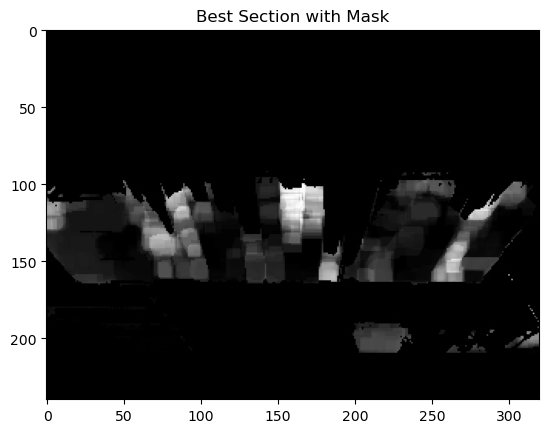

In [45]:
best_image_with_mask = cv2.bitwise_and(cumulative_sum, best_image)
plt.title('Best Section with Mask')
plt.imshow(best_image_with_mask)

In [ ]:
# draw a bounding box around best_image_with_mask where the pixels are > 0 [MAYBE TRY HIGHER VALUES or use val_threshold_bin]
# then show it
# Convert the image to the CV_8UC1 format
image_8uc1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find contours in the image
cnts = cv2.findContours(best_image_with_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Draw a bounding box around each contour
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 2)

# Display the image
plt.imshow(image)
